# Symmetric vs asymmetric parcellation


In [1]:
import sys
sys.path.append("..")
import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.export_atlas as ea
import ProbabilisticParcellation.scripts.atlas_paper.parcel_hierarchy as ph
import ProbabilisticParcellation.scripts.atlas_paper.evaluate_atlas as eva
import ProbabilisticParcellation.scripts.atlas_paper.symmetry as sym
import hierarchical_clustering as cl
from Functional_Fusion.dataset import *
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import torch as pt


In [2]:
figure_path = "/Users/jdiedrichsen/Dropbox (Diedrichsenlab)/papers/AtlasPaper/figure_parts/"
if not os.path.exists(figure_path):
    figure_path = "/Users/callithrix/Dropbox/AtlasPaper/figure_parts/"
atlas_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/ProbabilisticParcellationModel/Atlases/'


In [3]:
figsize = (20, 20)
model_pair = [
        "Models_03/NettekovenSym32_space-MNISymC2",
        "Models_03/NettekovenAsym32_space-MNISymC2",
    ]

atlas = 'MNISymC2'
dtype = 'func'
cmap = 'inferno'
cscale = (0.3, 1)
labels = None,
colorbar = True



# Group Symmetry

## Boundary Asymmetry (Group)


In [4]:
# Read in individual and group correlation
asym_sym_corr_group = np.load(f'{ut.model_dir}/Models/{model_pair[0]}_asym_sym_corr_group.npy')



/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_27124/31973836.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sb.histplot(


<AxesSubplot: ylabel='Count'>

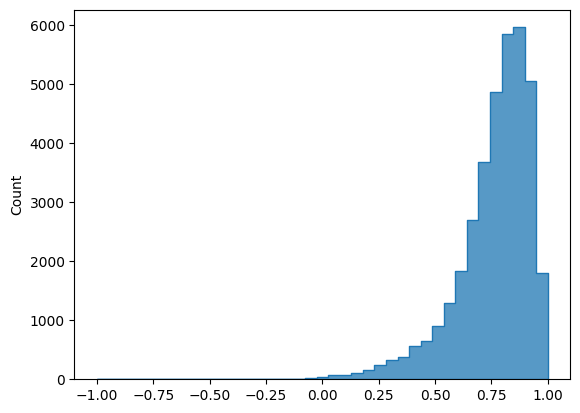

In [6]:
# Plot histogram of correlation
sb.histplot(
            x=asym_sym_corr_group.flatten(),
            element="step",
            palette="tab10",
            bins=np.linspace(-1, 1, 40),
        )
plt.xlabel('Correlation')

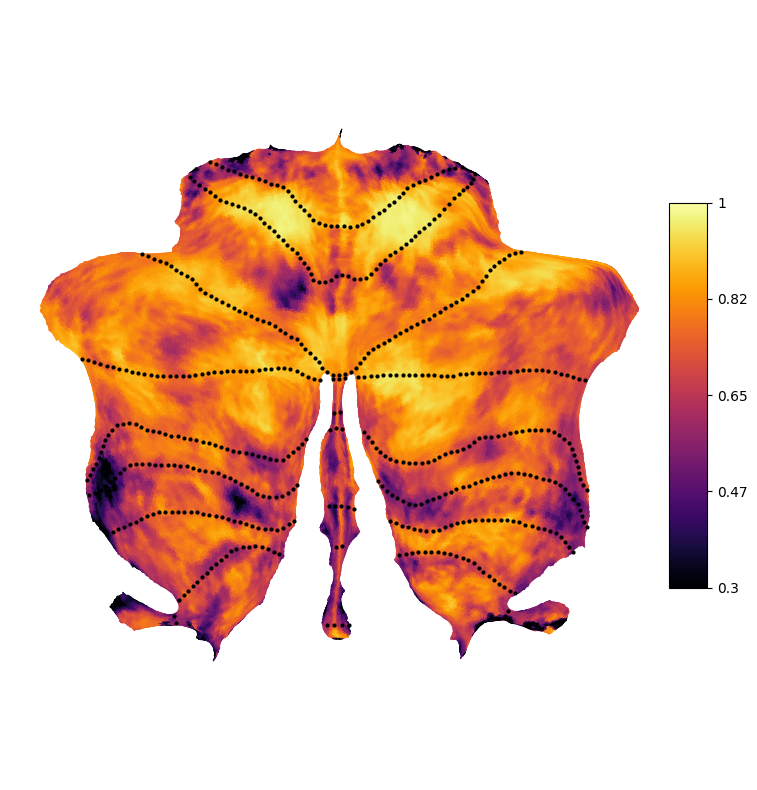

In [116]:

plt.figure(figsize=(10, 10))
ut.plot_data_flat(asym_sym_corr_group, atlas,
                       dtype=dtype,
                       render='matplotlib',
                       cmap='inferno',
                       cscale=cscale,
                       labels=labels,
                       colorbar=colorbar)
plt.savefig(figure_path + 'Symmetry_boundary_group.pdf', dpi=300,bbox_inches='tight')


## Functional Asymmetry (Group)

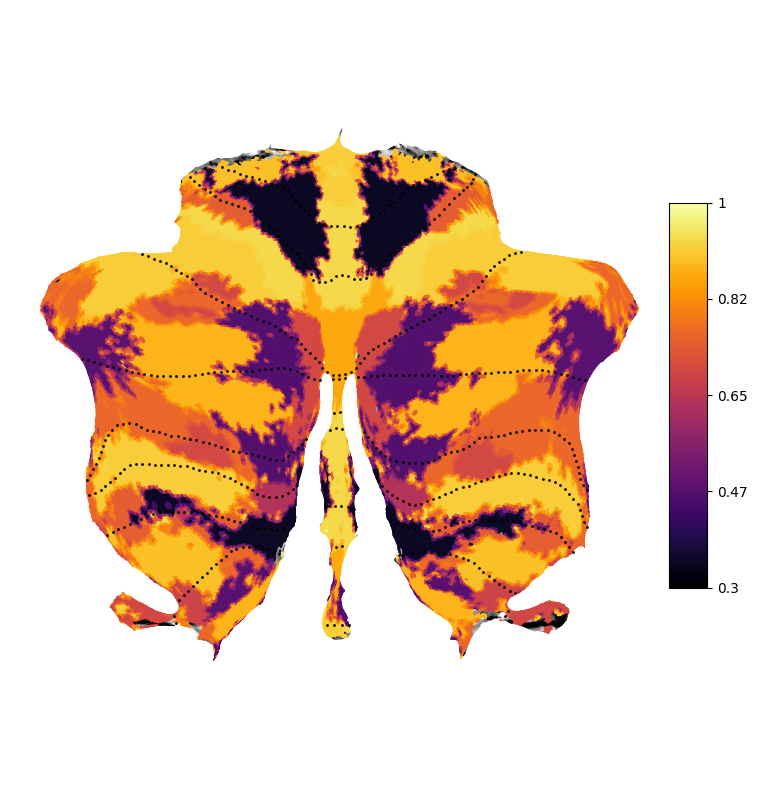

In [12]:
sym_score = sym.functional_symmetry(method='model', model_pair[0])
info, model = ut.load_batch_best(model_pair[0])
# Get winner take-all
Prob_32 = np.array(model.marginal_prob())
parcel_32 = Prob_32.argmax(axis=0) + 1
suit_atlas, _ = am.get_atlas(info.atlas, ut.base_dir + "/Atlases")
# Map the symmetry to the parcels 
Nifti = suit_atlas.data_to_nifti(parcel_32.astype(float))  
surf_parcel = suit.flatmap.vol_to_surf(Nifti, stats='mode',
                                       space='MNISymC', ignore_zeros=True)
surf_parcel = np.nan_to_num(surf_parcel, copy=False).astype(int)

sym_map_32 = np.zeros(surf_parcel.shape) * np.nan
sym_map_32[surf_parcel > 0] = sym_score[surf_parcel[surf_parcel > 0] - 1]

# Plot the symmetry map
plt.figure(figsize=(10, 10))
suit.flatmap.plot(sym_map_32,
                    render='matplotlib',
                    overlay_type='func',
                    new_figure=False,
                    colorbar=True,
                    cscale=cscale,
                    cmap=cmap)
plt.savefig(figure_path + 'Symmetry_profile_group_32.png',
            dpi=300, bbox_inches='tight')


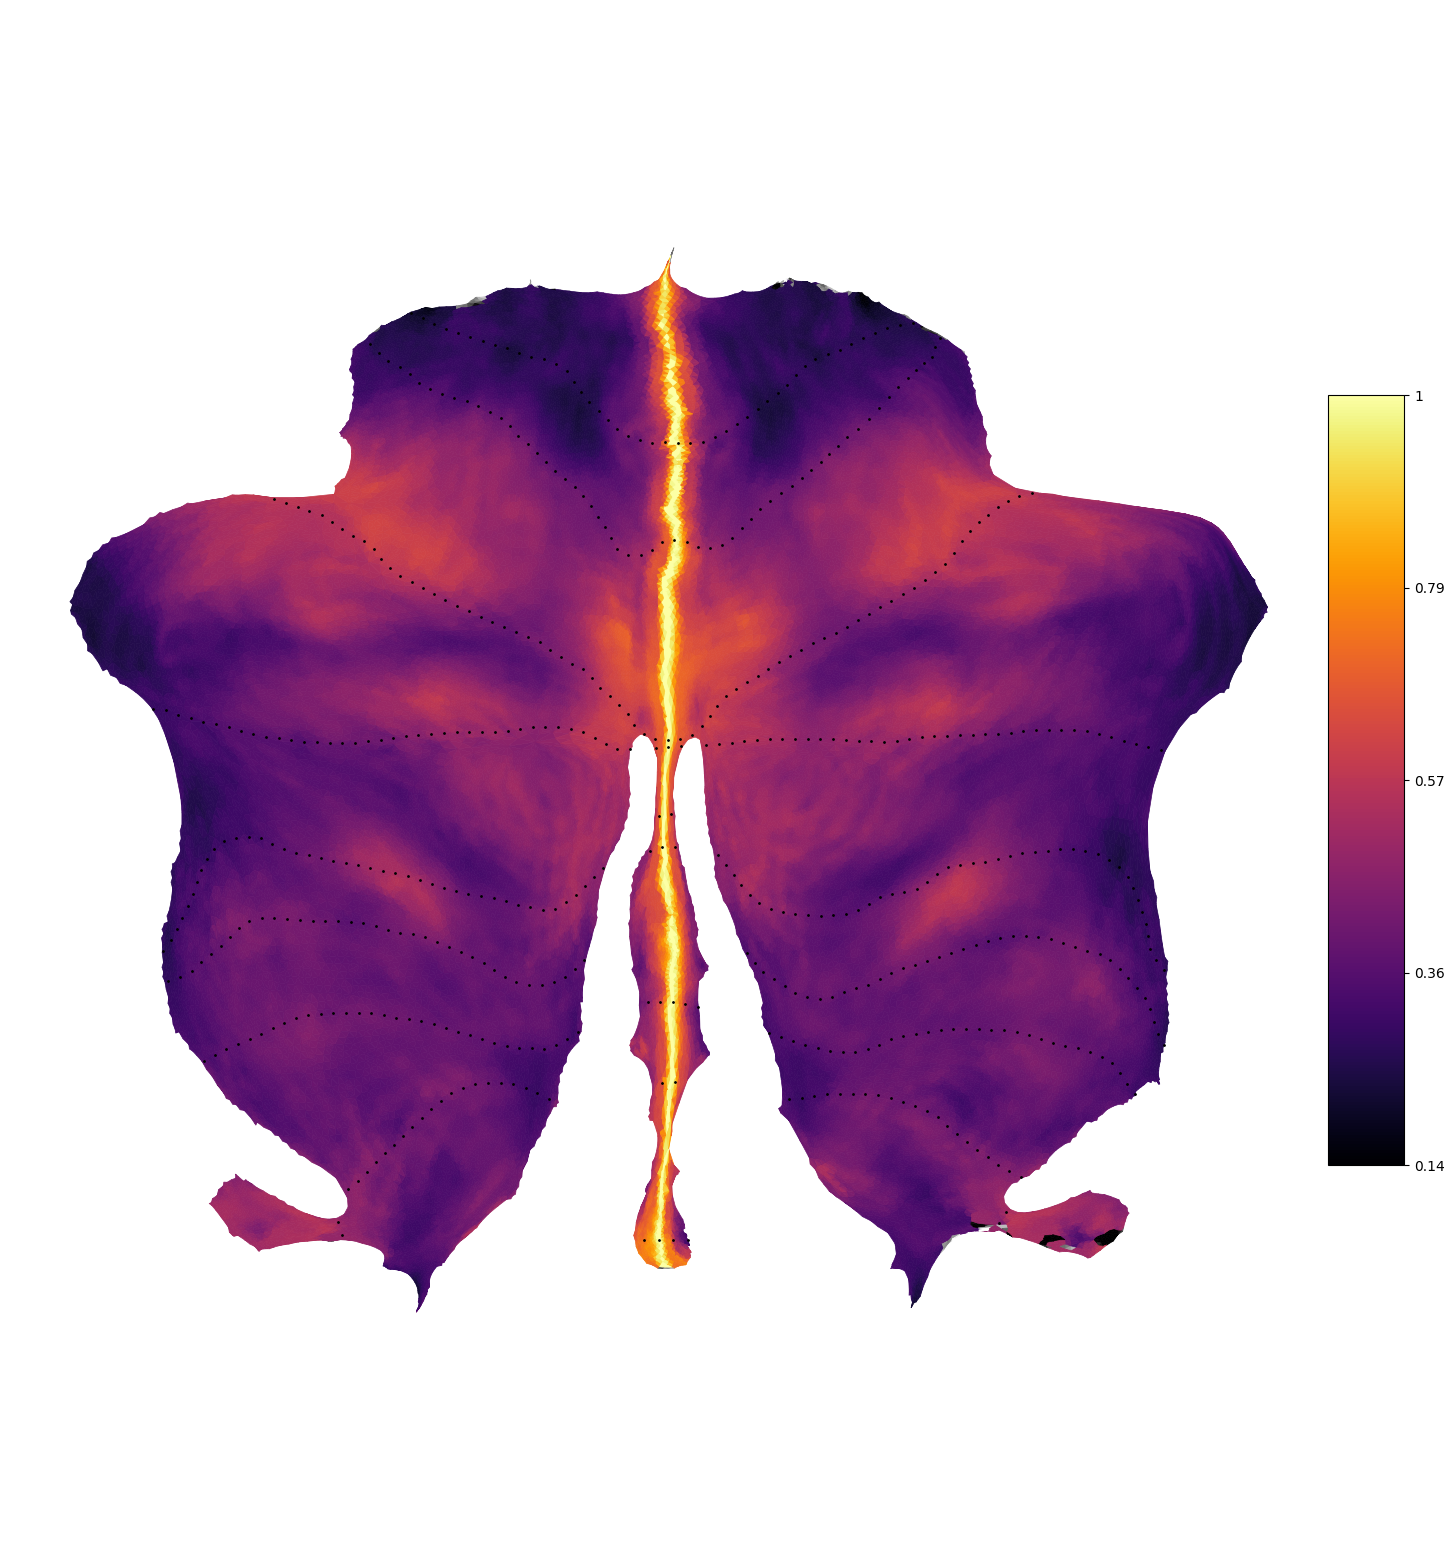

In [29]:
sym_score = np.load(
    f'{ut.model_dir}/Models/Evaluation/nettekoven_68/functional_sim_data.npy')
sym_score_avg = np.nanmean(
    sym_score, axis=0).squeeze().astype(float)

Nifti = suit_atlas.data_to_nifti(sym_score_avg)
sym_score_avg_surf = suit.flatmap.vol_to_surf(Nifti, stats='nanmean',
                                       space='MNISymC', ignore_zeros=False)
# Plot the symmetry map
plt.figure(figsize=figsize)
suit.flatmap.plot(surf_parcel,
                  render='matplotlib',
                  overlay_type='func',
                  new_figure=False,
                  colorbar=True,
                  cmap='inferno')
plt.savefig(figure_path + 'Symmetry_functional_individual.png',
            dpi=300, bbox_inches='tight')

In [13]:
# Load number of participants
T = pd.read_csv(ut.base_dir + '/dataset_description.tsv', sep='\t')
n_subjects = T.num_particpants[:7].values
# Make index start at 0
sub_cumulative = np.cumsum(n_subjects)-1
# print(sub_cumulative)


In [17]:
# Loop through n_subjects and group correlation by dataset
functional_sim_dataset = []
for i in range(len(n_subjects)):
    # print subjects to average to check subject indexing is correct
    if i == 0:
        # print(sub_cumulative[i])
        functional_sim_dataset.append(
            np.nanmean(sym_score[:sub_cumulative[i]],axis=0))
    else:
        # print(sub_cumulative[i-1]+1, sub_cumulative[i])
        functional_sim_dataset.append(
            np.nanmean(sym_score[sub_cumulative[i - 1] + 1:sub_cumulative[i]],axis=0))


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_89121/2342076890.py:8: RuntimeWarning: Mean of empty slice
  np.nanmean(sym_score[:sub_cumulative[i]],axis=0))
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_89121/2342076890.py:12: RuntimeWarning: Mean of empty slice
  np.nanmean(sym_score[sub_cumulative[i - 1] + 1:sub_cumulative[i]],axis=0))


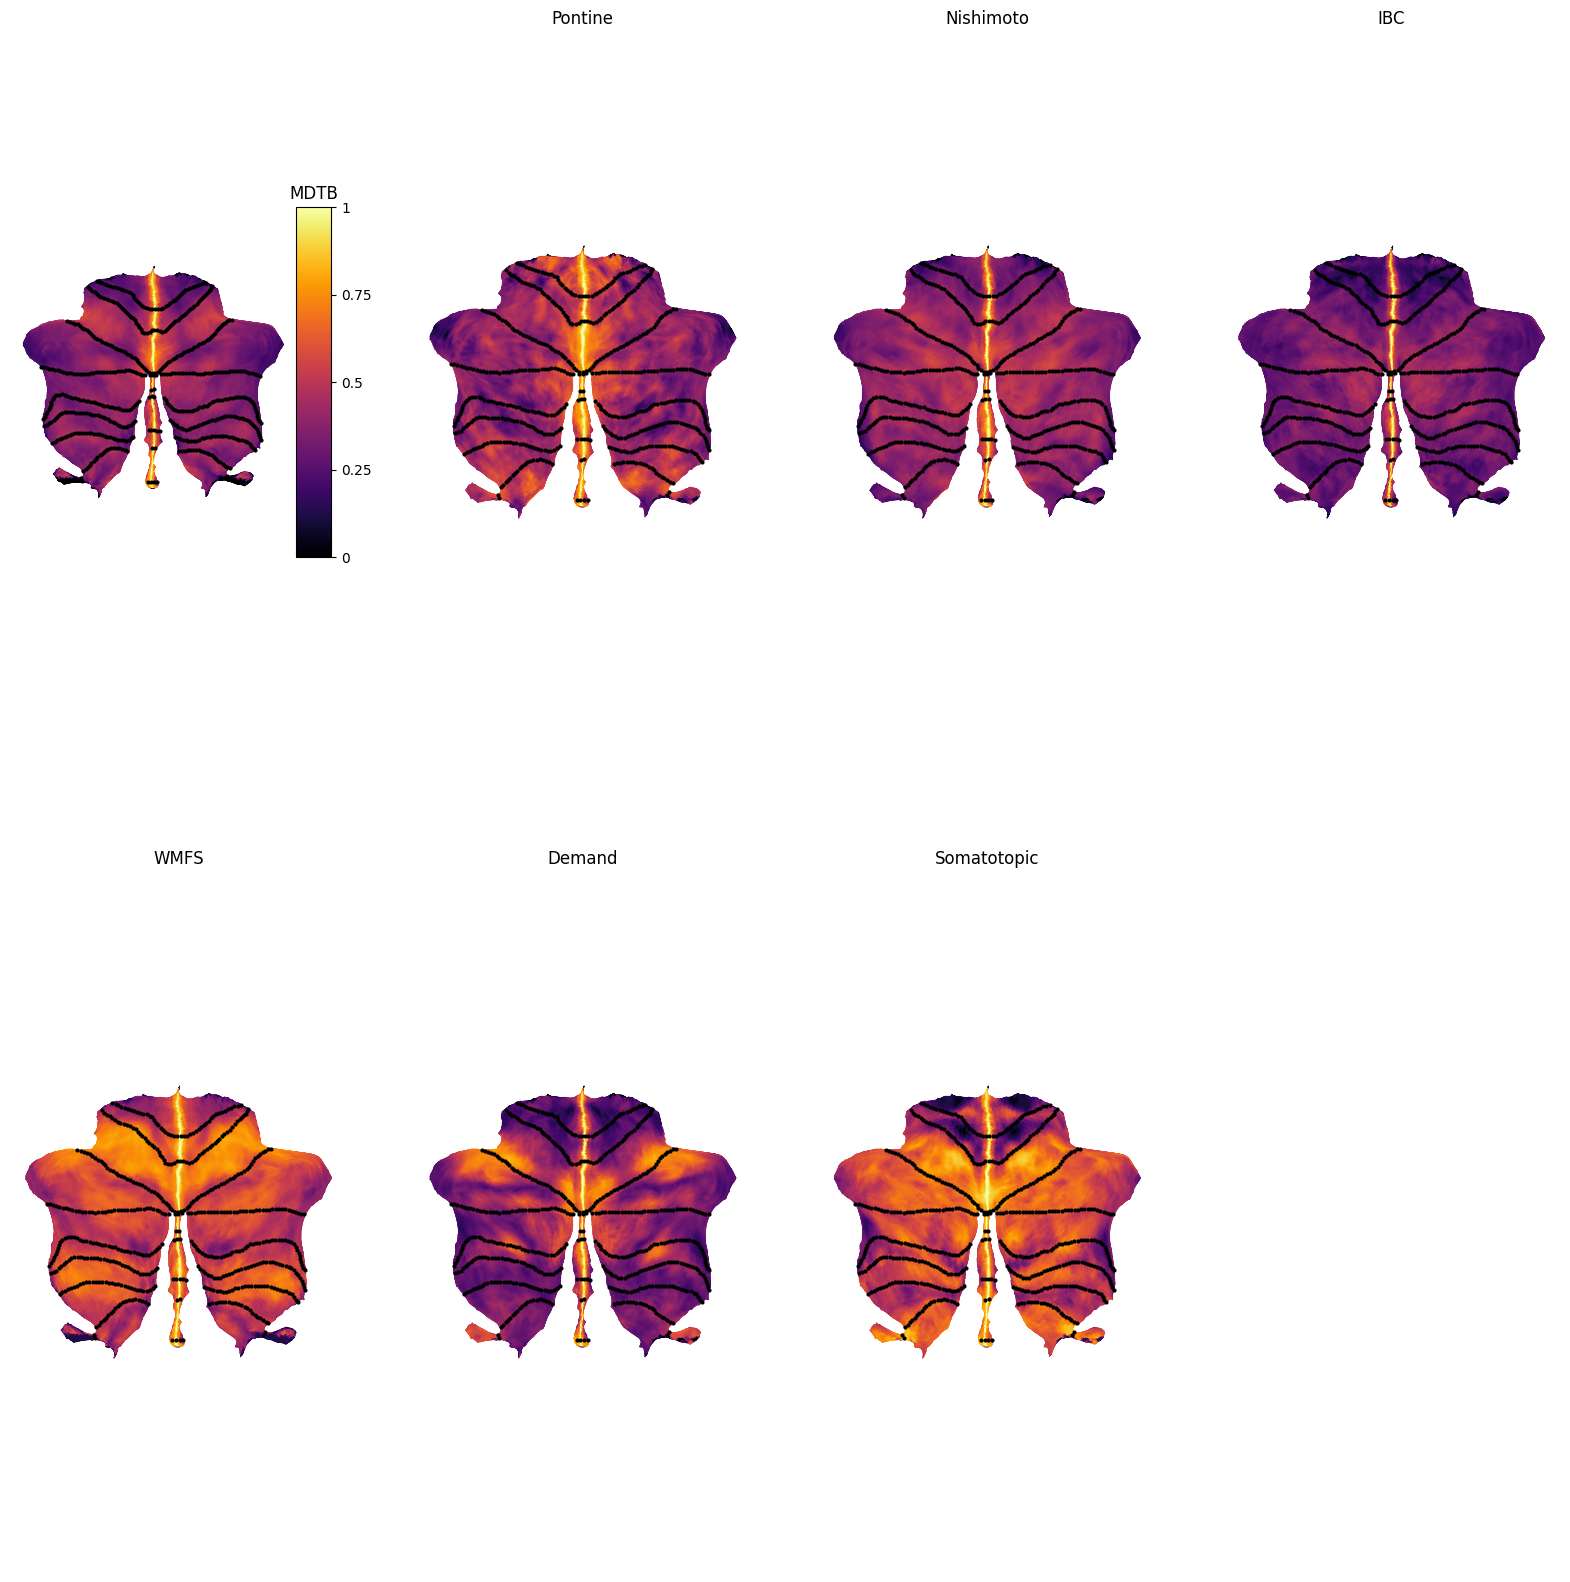

In [18]:
# Plot the results by dataset
plt.figure(figsize=(20, 20))
ut.plot_multi_flat(functional_sim_dataset, 'MNISymC2',
                   dtype='func',
                   grid=(2, 4),
                   colorbar=True,
                   titles=T.name[:-1].values,
                   cmap='inferno')
plt.savefig(figure_path + 'Symmetry_functional_individual_datasetwise.pdf',
            dpi=300, bbox_inches='tight')


In [37]:

info, model = ut.load_batch_best(model_pair[0])
# Get winner take-all
Prob_32 = np.array(model.marginal_prob())
parcel_32 = Prob_32.argmax(axis=0) + 1
Nifti = suit_atlas.data_to_nifti(parcel_32.astype(float))
surf_parcel = suit.flatmap.vol_to_surf(Nifti, stats='mode',
                                       space='MNISymC', ignore_zeros=True)
surf_parcel = np.nan_to_num(surf_parcel, copy=False).astype(int)
sym_map_32 = np.zeros(surf_parcel.shape) * np.nan
sym_map_32[surf_parcel >
           0] = functional_sim_dataset[0][surf_parcel[surf_parcel > 0] - 1].squeeze()

# Plot the symmetry map
plt.figure(figsize=(10, 10))
suit.flatmap.plot(sym_map_32,
                  render='matplotlib',
                  overlay_type='func',
                  new_figure=False,
                  colorbar=True,
                  cscale=cscale,
                  cmap=cmap)
plt.savefig(figure_path + 'Symmetry_data_indiv_parcel.png',
            dpi=300, bbox_inches='tight')


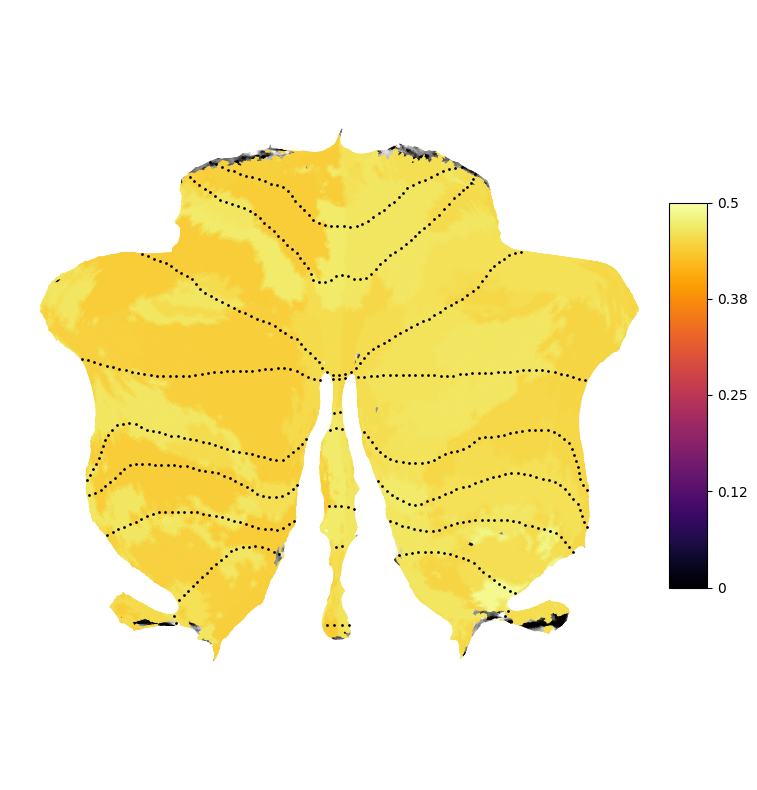

In [35]:

# Plot the symmetry map
plt.figure(figsize=(10, 10))
suit.flatmap.plot(sym_map_32,
                  render='matplotlib',
                  overlay_type='func',
                  new_figure=False,
                  colorbar=True,
                  cscale=(0, 0.5),
                  cmap=cmap)
plt.savefig(figure_path + 'Symmetry_data_indiv_parcel.png',
            dpi=300, bbox_inches='tight')


# Individual Asymmetry

## Boundary Asymmetry (Individual)


In [7]:
asym_sym_corr_indiv = np.load(
    f'{ut.model_dir}/Models/{model_pair[0]}_asym_sym_corr_indiv.npy')


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_27124/3299620461.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sb.histplot(


Text(0.5, 0, 'Correlation')

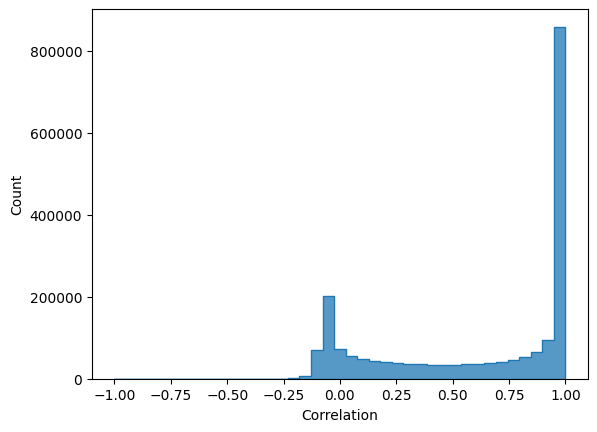

In [9]:
# Plot histogram of correlation
sb.histplot(
            x=asym_sym_corr_indiv.flatten(),
            element="step",
            palette="tab10",
            bins=np.linspace(-1, 1, 40),
        )
plt.xlabel('Correlation')

In [111]:
# Loop through n_subjects and group correlation by dataset
corr_dataset = []
for i in range(len(n_subjects)):
    # print subjects to average to check subject indexing is correct
    if i == 0:
        # print(sub_cumulative[i])
        corr_dataset.append(asym_sym_corr_indiv[:sub_cumulative[i]].mean(axis=0))
    else:
        # print(sub_cumulative[i-1]+1, sub_cumulative[i])
        corr_dataset.append(
            asym_sym_corr_indiv[sub_cumulative[i-1]+1:sub_cumulative[i]].mean(axis=0))


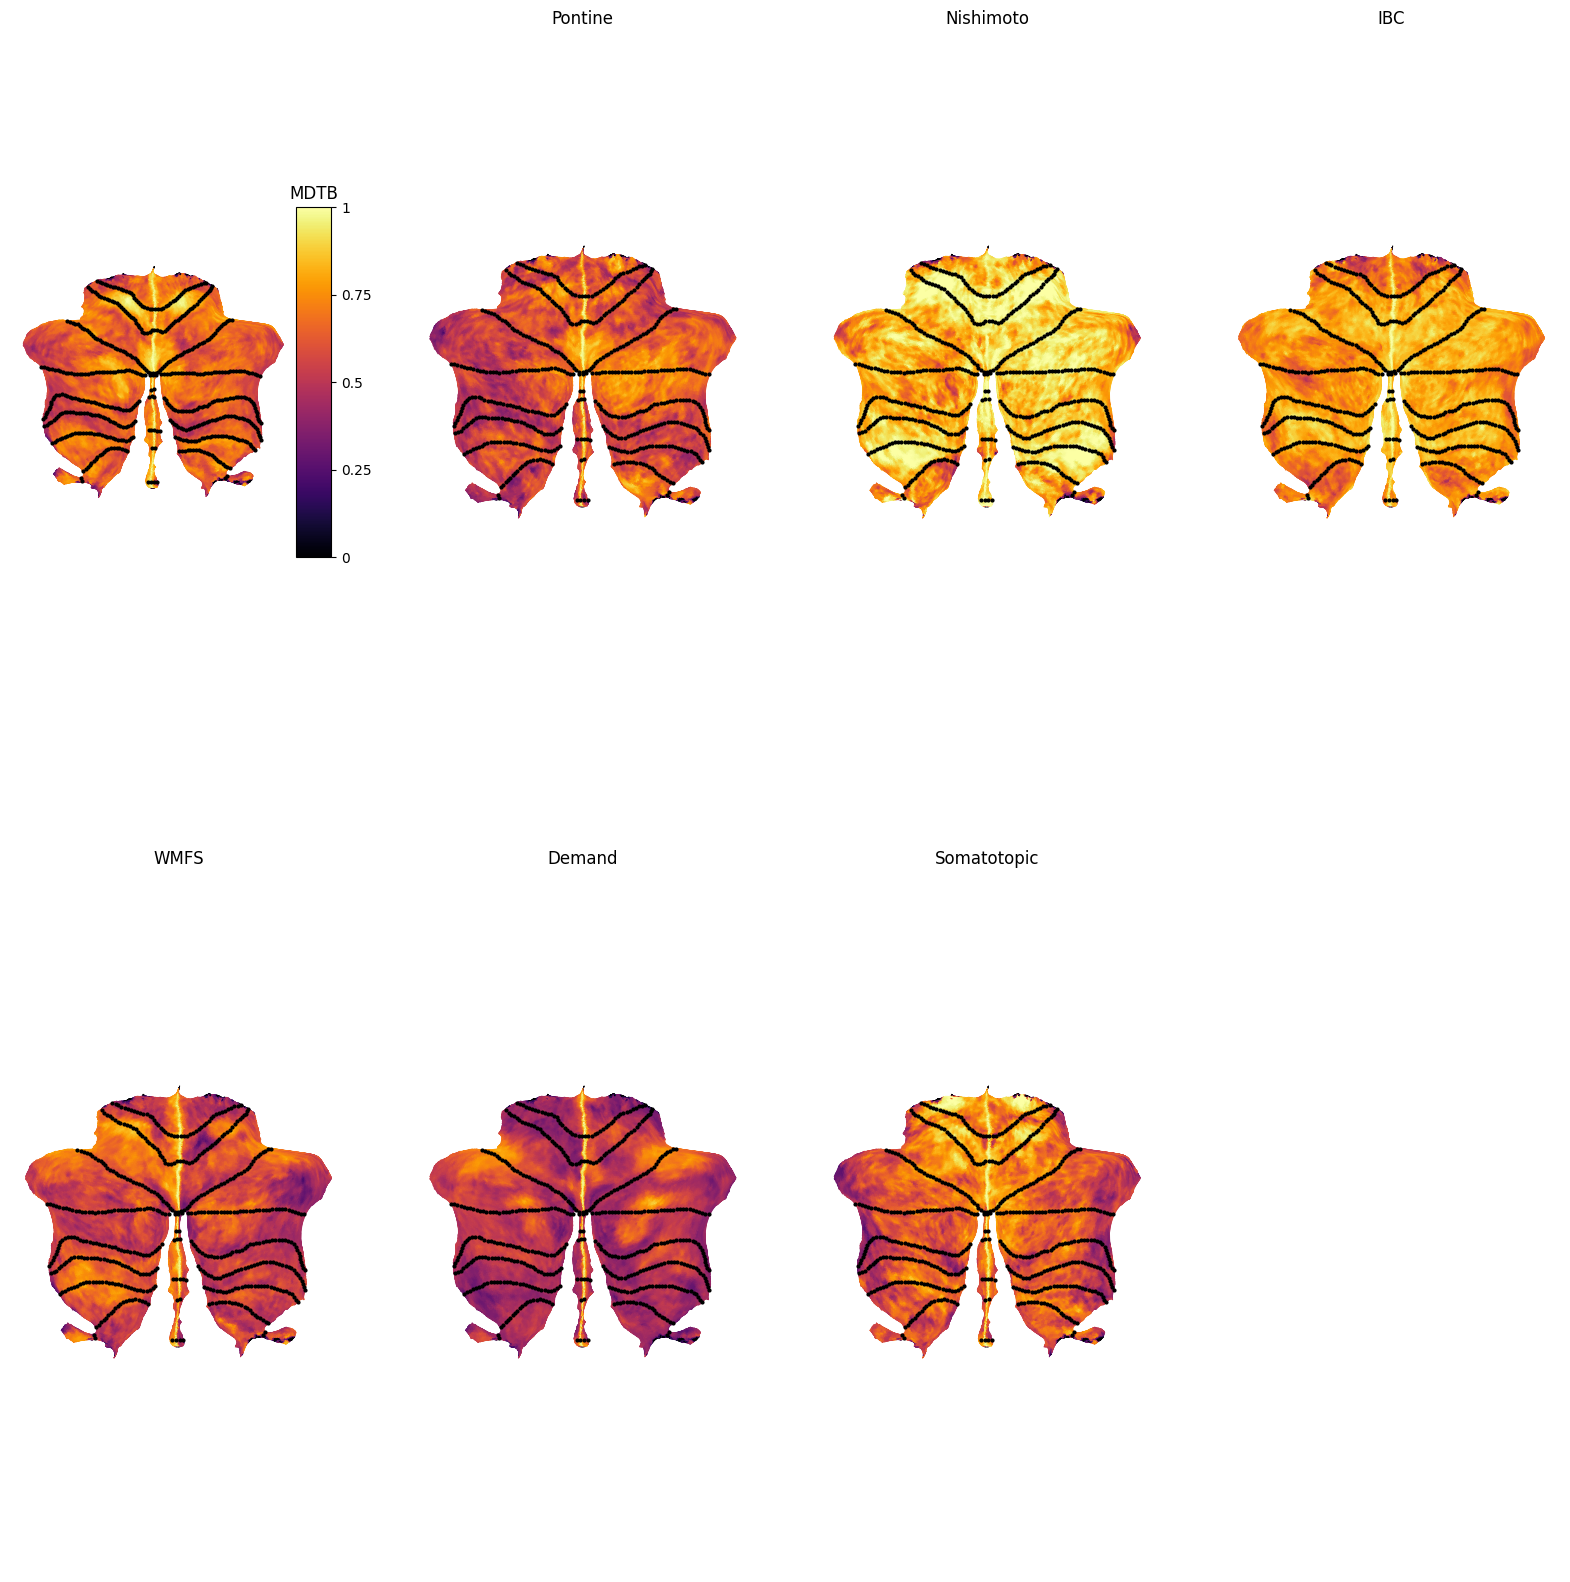

In [112]:
# Plot the results by dataset
plt.figure(figsize=(20, 20))
ut.plot_multi_flat(corr_dataset, 'MNISymC2',
                   dtype='func',
                   grid=(2, 4),
                   colorbar=True,
                   cscale=(0, 1),
                   titles=T.name[:-1].values,
                   cmap='inferno')
plt.savefig(figure_path + 'Symmetry_boundary_individual_datasetwise.pdf',
            dpi=300, bbox_inches='tight')


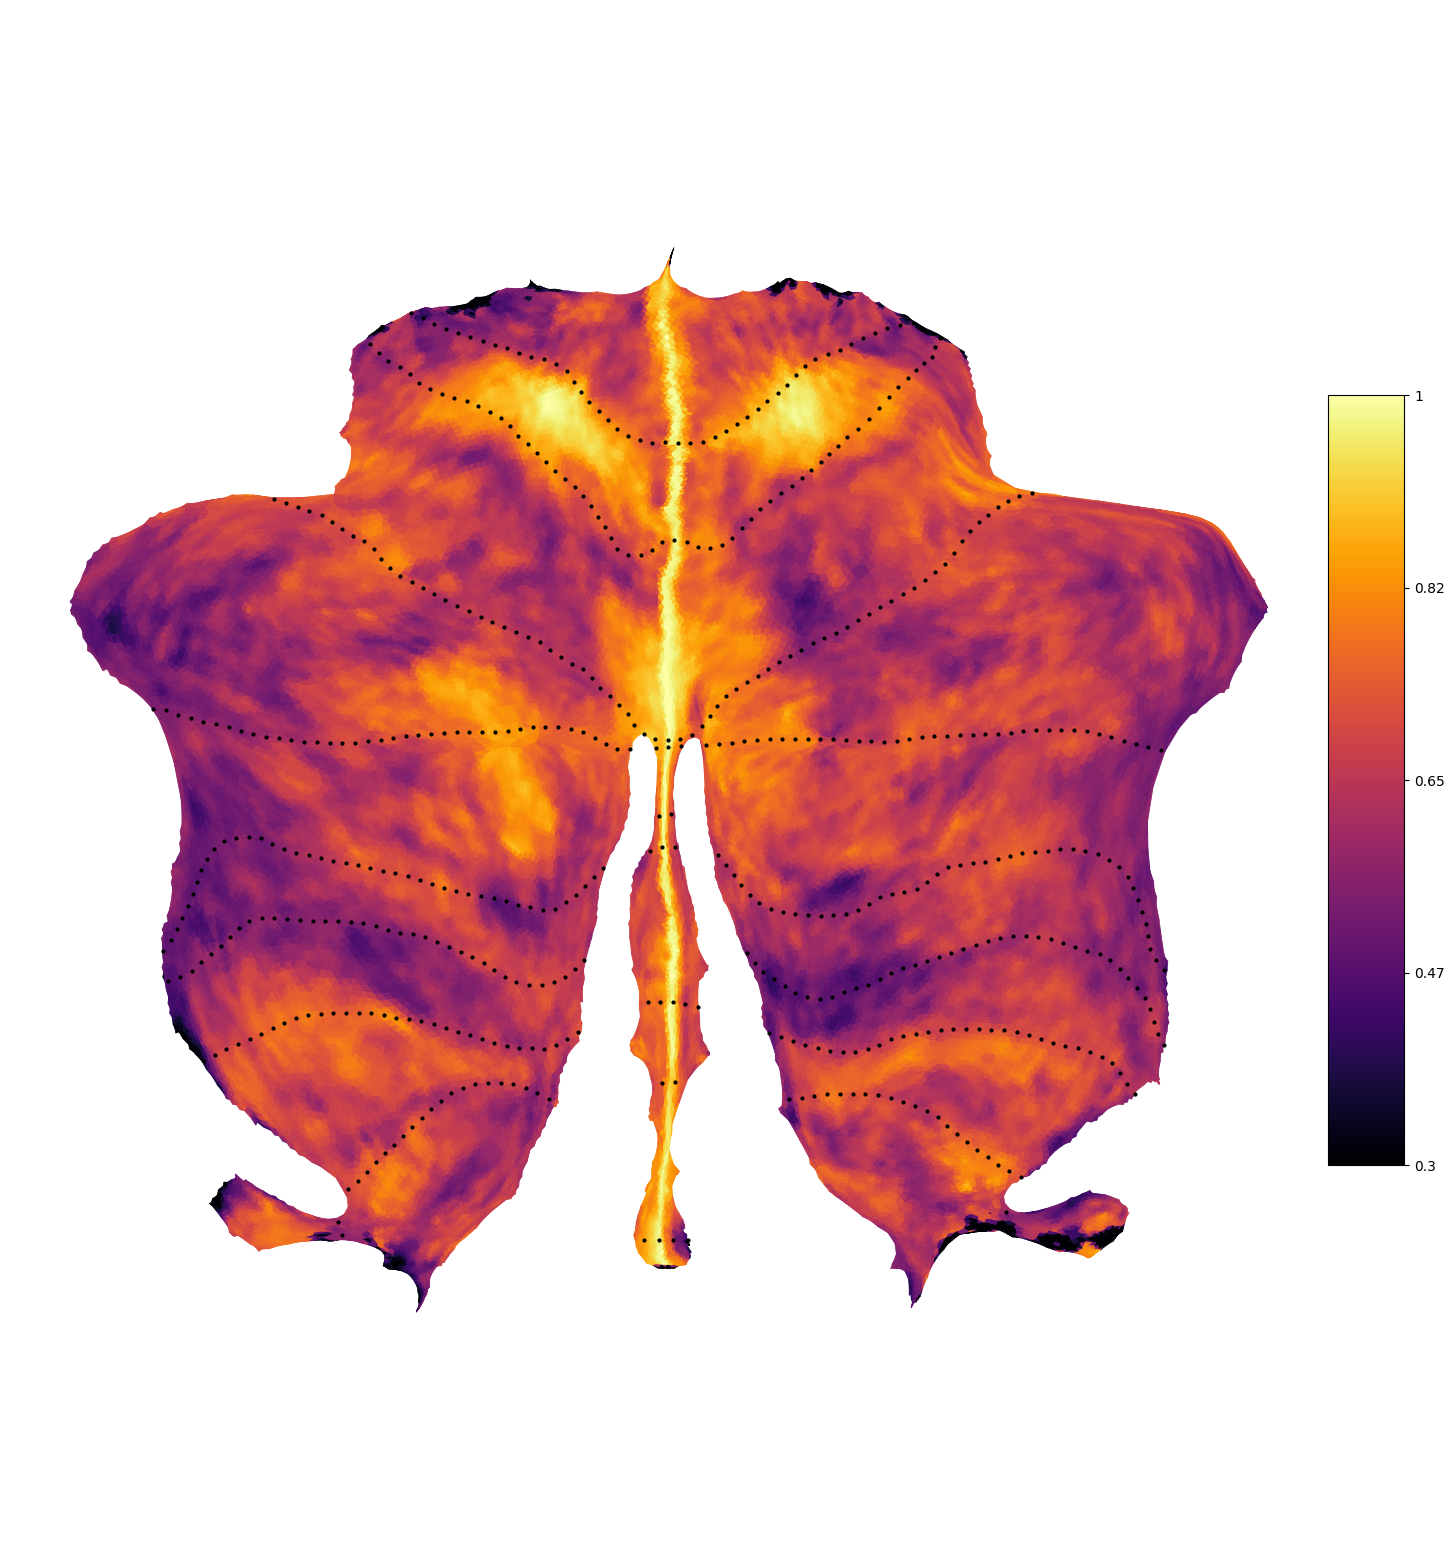

In [117]:
# Plot the results by dataset
plt.figure(figsize=figsize)
ut.plot_data_flat(corr_dataset[T.two_letter_code.tolist().index('Md')
                               ], 'MNISymC2',
                   dtype='func',
                   colorbar=True,
                   cscale=cscale,
                   cmap='inferno')
plt.savefig(figure_path + 'Symmetry_boundary_individual_MDTB.png',
            dpi=300, bbox_inches='tight')


## Average only symmetric datasets (Md, Po, Wm, De, So)

In [113]:
# Average symmetric datasets
symmetric_datasets = ['Md', 'Po', 'Wm', 'De', 'So']
# Get indices of symmetric datasets
symmetric_indices = [i for i, x in enumerate(T.two_letter_code) if x in symmetric_datasets]

# Collect only numpy arrays from symmetric indices
corr_dataset_sym = [corr_dataset[i] for i in symmetric_indices]

# Stack
corr_dataset_sym = np.stack(corr_dataset_sym, axis=0)
# Average
corr_dataset_sym = corr_dataset_sym.mean(axis=0)


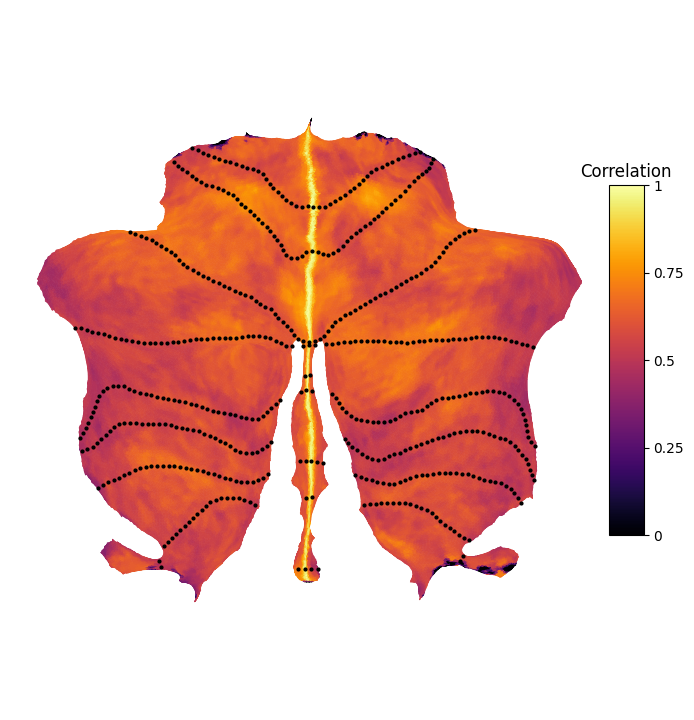

In [114]:
plt.figure(figsize=(20, 20))
ut.plot_multi_flat([corr_dataset_sym], 'MNISymC2',
                   grid=(2, 2),
                   dtype='func',
                   colorbar=True,
                   cscale=(0, 1),
                   cmap='inferno',
                    titles=['Correlation'])
plt.savefig(figure_path + 'Symmetry_boundary_symmetric-datasets.png',
            dpi=300, bbox_inches='tight')
